<a href="https://colab.research.google.com/github/mgersins-design/Machine-Learning/blob/main/Final/FCNN_Cardiovascular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import datetime

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/CVD_cleaned.csv'
data = pd.DataFrame(pd.read_csv(file_path))
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [ ]:
# Checking Null values
data.isnull().sum()*100/data.shape[0]
# There are no NULL values in the dataset, hence it is clean.

,0
General_Health,0.0
Checkup,0.0
Exercise,0.0
Heart_Disease,0.0
Skin_Cancer,0.0
Other_Cancer,0.0
Depression,0.0
Diabetes,0.0
Arthritis,0.0
Sex,0.0


In [ ]:
# Handle Age_Category ranges (convert to numeric midpoints)
age_map = {
    '18-24': 21,
    '25-29': 27,
    '30-34': 32,
    '35-39': 37,
    '40-44': 42,
    '45-49': 47,
    '50-54': 52,
    '55-59': 57,
    '60-64': 62,
    '65-69': 67,
    '70-74': 72,
    '75-79': 77,
    '80': 80,
    '80+': 81
}

# Apply mapping
data['Age_Category'] = data['Age_Category'].replace(age_map)
# Ensure the column is numeric after replacement
data['Age_Category'] = pd.to_numeric(data['Age_Category'], errors='coerce')

data.head()

/tmp/ipython-input-3022104478.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Age_Category'] = data['Age_Category'].replace(age_map)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,72,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,72,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,62,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,77,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,81,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [ ]:
## Encode categorical variables
from sklearn.preprocessing import LabelEncoder

binary_cols = ['General_Health', 'Exercise', 'Heart_Disease',
               'Skin_Cancer', 'Other_Cancer', 'Depression', 'Arthritis', 'Sex',
               'Smoking_History']
for col in binary_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,3,Within the past 2 years,0,0,0,0,0,No,1,0,72,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,4,Within the past year,0,1,0,0,0,Yes,0,0,72,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,4,Within the past year,1,0,0,0,0,Yes,0,0,62,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,3,Within the past year,1,1,0,0,0,Yes,0,1,77,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,2,Within the past year,0,0,0,0,0,No,0,1,81,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0


In [ ]:
## One-hot encoding for Checkup and diabetes column
data = pd.get_dummies(
    data,
    columns=['Checkup', 'Diabetes'],
    drop_first=False,
    dtype=int
)

data.head()

,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Arthritis,Sex,Age_Category,Height_(cm),...,FriedPotato_Consumption,Checkup_5 or more years ago,Checkup_Never,Checkup_Within the past 2 years,Checkup_Within the past 5 years,Checkup_Within the past year,Diabetes_No,"Diabetes_No, pre-diabetes or borderline diabetes",Diabetes_Yes,"Diabetes_Yes, but female told only during pregnancy"
0,3,0,0,0,0,0,1,0,72,150.0,...,12.0,0,0,1,0,0,1,0,0,0
1,4,0,1,0,0,0,0,0,72,165.0,...,4.0,0,0,0,0,1,0,0,1,0
2,4,1,0,0,0,0,0,0,62,163.0,...,16.0,0,0,0,0,1,0,0,1,0
3,3,1,1,0,0,0,0,1,77,180.0,...,8.0,0,0,0,0,1,0,0,1,0
4,2,0,0,0,0,0,0,1,81,191.0,...,0.0,0,0,0,0,1,1,0,0,0


In [ ]:
# Splitting the data into training and validation set
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_df = data.iloc[train_indices]
val_df = data.iloc[val_indices]

y_train = train_df['Heart_Disease']
y_val = val_df['Heart_Disease']
x_train = train_df.drop('Heart_Disease', axis=1)
x_val = val_df.drop('Heart_Disease', axis=1)

In [ ]:
# Converting data into pytorch tensors
x_train = torch.tensor(x_train.values, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32)
x_test = torch.tensor(x_val.values, dtype = torch.float32)
y_test = torch.tensor(y_val.values, dtype = torch.float32)

In [ ]:
# Normalizing the inputs by fitting on the train dataset and apply it on the validation dataset
mean = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [ ]:
# Implementing DataLoaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_test, y_test)

# Faster training with higher batch_size and loading the data parallel on two cpus (num_workers)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256 , shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Switching to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [ ]:
num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
print(f"Healthy: {num_negatives}, Disease: {num_positives}")
print(f"Amount of Healthy: {num_negatives / len(y_train):.2%}")

Healthy: 227130, Disease: 19954
Amount of Healthy: 91.92%


Accuracy Trap: dataset contains far more healthy patiensts than sick patients, which is why the val accuracy stays constant at around 0.92 -> model is ignoring the sick patients completely because it's mathematically "safer" to just guess the majority class rather than to try to learn the complex features of the disease.

Solution: Implementing class weights

In [ ]:
#pos_weight = (num_negatives / num_positives).to(device)
pos_weight = torch.tensor([5.0]).to(device)

In [ ]:
# FCNN-Model architecture
class HeartDiseasesFCNN (nn.Module):
  def __init__(self, input_size):
    super(HeartDiseasesFCNN, self).__init__()
    self.fc1 = nn.Linear(input_size, 64)
    self.bn1 = nn.BatchNorm1d(64)
    self.fc2 = nn.Linear(64, 32)
    self.bn2 = nn.BatchNorm1d(32)
    self.fc3 = nn.Linear(32, 1)
    self.relu = nn.ReLU()
    #self.sigmoid = nn.Sigmoid() no more sigmoid here, to update weights
    self.dropout = nn.Dropout(0.3) # dropping out 30% of random neurons

  def forward(self, x):
    out = self.fc1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.dropout(out)

    out = self.fc2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.dropout(out)

    out = self.fc3(out)
    return out # Returns logits

In [ ]:
# Training and validation function
def train_and_validate(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
  device = next(model.parameters()).device

  train_losses = []
  val_losses = []

  for epoch in range(1, n_epochs+1):
    # Training Phase
    model.train()
    loss_train = 0.0

    for inputs, labels in train_loader:
      inputs = inputs.to(device = device)
      labels = labels.to(device = device).unsqueeze(1)

      logits = model(inputs)
      loss = loss_fn(logits, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    model.eval()
    loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs = inputs.to(device = device)
        labels = labels.to(device = device).unsqueeze(1)

        logits = model(inputs)

        # Validation loss
        loss = loss_fn(logits, labels)
        loss_val += loss.item()

        # Apply sigmoid manually for prediction of accuracy
        probs = torch.sigmoid(logits) # Change of logits in values between 0.0 and 1.0
        predicted = (probs >= 0.5).float() # Cutoff in 0 or 1

        total_val += labels.shape[0]
        correct_val += (predicted == labels).sum().item()

    avg_loss = loss_train / len(train_loader)
    avg_val_loss = loss_val / len(val_loader)
    acc_val = correct_val / total_val

    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {:3d}, Training loss {:.4f}, Validation Accuracy: {:.2f}'.format(
          datetime.datetime.now(), epoch, avg_loss, acc_val))

  print("Training is done.")
  return train_losses, val_losses

In [ ]:
 # Initializing the Model
input_features = x_train.shape[1]
model = HeartDiseasesFCNN(input_features).to(device)

# Loss and Optimizer
# Use of weighted loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Start of the training
print("Training is starting...")
n_epochs = 50
train_losses, val_losses = train_and_validate(n_epochs = n_epochs,
                   optimizer = optimizer,
                   model = model,
                   loss_fn = loss_fn,
                   train_loader = train_loader,
                   val_loader = val_loader)

Training is starting...
2025-11-27 23:17:33.387161 Epoch   1, Training loss 0.6570, Validation Accuracy: 0.81
2025-11-27 23:18:05.857928 Epoch  10, Training loss 0.6148, Validation Accuracy: 0.83
2025-11-27 23:18:41.457367 Epoch  20, Training loss 0.6097, Validation Accuracy: 0.85
2025-11-27 23:19:17.343538 Epoch  30, Training loss 0.6058, Validation Accuracy: 0.84
2025-11-27 23:19:52.728337 Epoch  40, Training loss 0.6050, Validation Accuracy: 0.85
2025-11-27 23:20:27.989847 Epoch  50, Training loss 0.6016, Validation Accuracy: 0.84
Training is done.


In [ ]:
# Model Complexity
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(3969, [1600, 64, 64, 64, 2048, 32, 32, 32, 32, 1])

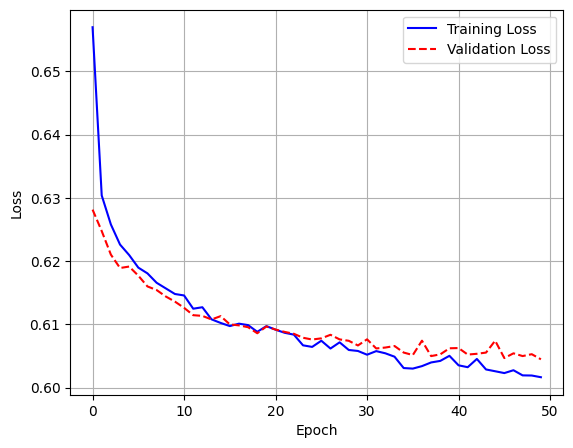

In [ ]:
# Plot of training and validation loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Schritt 1: Daten sammeln (Inference) ---
model.eval()
all_probs = [] # saving the possibilities instead of states (0/1)
all_labels = []

# Wir gehen die Validierungsdaten durch und speichern Vorhersagen & echte Werte
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(inputs)
        probs = torch.sigmoid(logits)
        #predicted = (probs >= 0.8).float()

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# In flache Numpy-Arrays umwandeln (Wichtig für sklearn!)
Y_test = np.array(all_labels).flatten()
Y_pred = np.array(all_probs).flatten()


# --- Schritt 2: Deine Metriken berechnen ---

# Adding the threshold to improve metric accuracies
Threshold = 0.25
Y_pred = (Y_pred >= Threshold).astype(int)

# Metrics
cnf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cnf_matrix)
print("-" * 30)
print("Accuracy:  {:.4f}".format(accuracy_score(Y_test, Y_pred)))
print("Precision: {:.4f}".format(precision_score(Y_test, Y_pred)))
print("Recall:    {:.4f}".format(recall_score(Y_test, Y_pred)))
print("F1-Score:  {:.4f}".format(f1_score(Y_test, Y_pred)))
print("-" * 30)

Confusion Matrix:
[[36062 20691]
 [  678  4339]]
------------------------------
Accuracy:  0.6541
Precision: 0.1734
Recall:    0.8649
F1-Score:  0.2888
------------------------------


Text(0.5, 427.9555555555555, 'Predicted label')

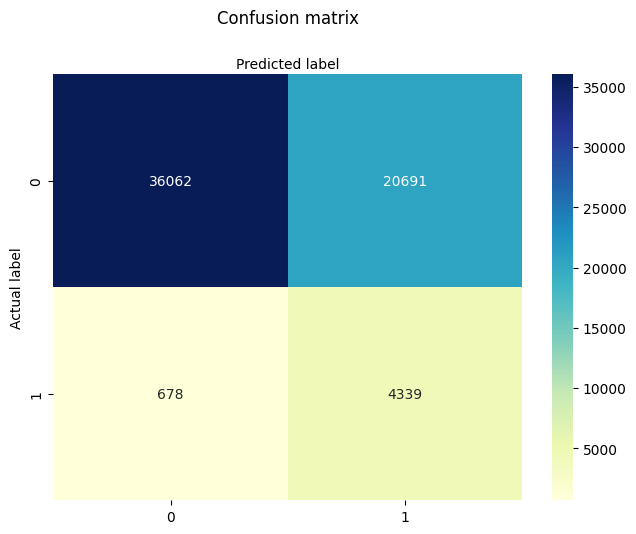

In [ ]:
#Let's visualize the results of the model in the form of a confusion matrix using matplotlib and seaborn.
#Here, you will visualize the confusion matrix using Heatmap.
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')